In [54]:
import glob
from pathlib import Path
from typing import List

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from colour import Color
from scipy.spatial.transform import Rotation

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.axes._axes import Axes

from IPython.core.debugger import set_trace
from typing import Any, Callable, List, Tuple

In [38]:

def load_image(path: str) -> np.ndarray:
    return cv2.imread(path)[:, :, ::-1]

In [ ]:
def get_matches(pic_a: np.ndarray, pic_b: np.ndarray, n_feat: int) -> (np.ndarray, np.ndarray):
    """Get unreliable matching points between two images using SIFT.

    Args:
        pic_a: a numpy array representing image 1.
        pic_b: a numpy array representing image 2.
        n_feat: an int representing number of matching points required.

    Returns:
        pts_a: a numpy array representing image 1 points.
        pts_b: a numpy array representing image 2 points.
    """
    pic_a = cv2.cvtColor(pic_a, cv2.COLOR_BGR2GRAY)
    pic_b = cv2.cvtColor(pic_b, cv2.COLOR_BGR2GRAY)

    try:
        sift = cv2.xfeatures2d.SIFT_create()
    except:
        sift = cv2.SIFT_create()

    kp_a, desc_a = sift.detectAndCompute(pic_a, None)
    kp_b, desc_b = sift.detectAndCompute(pic_b, None)
    dm = cv2.BFMatcher(cv2.NORM_L2)
    matches = dm.knnMatch(desc_b, desc_a, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance / n.distance <= 0.8:
            good_matches.append(m)
    pts_a = []
    pts_b = []
    for m in good_matches[: int(n_feat)]:
        pts_a.append(kp_a[m.trainIdx].pt)
        pts_b.append(kp_b[m.queryIdx].pt)

    return np.asarray(pts_a), np.asarray(pts_b)

In [69]:
import cv2
import numpy as np
from typing import Tuple

def get_matches_ORB(
    img1: np.ndarray,
    img2: np.ndarray,
    K: np.ndarray,
    fmat: bool = True
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Detect and match ORB features between two images, estimate the Fundamental and Essential matrices,
    and return the inlier matched points.

    Args:
        img1 (np.ndarray): The first image (grayscale or color).
        img2 (np.ndarray): The second image (grayscale or color).
        K (np.ndarray): The camera intrinsic matrix (3x3).
        fmat (bool): Flag indicating whether to compute the Fundamental matrix. If False, only match features.

    Returns:
        F (np.ndarray): The estimated Fundamental matrix (3x3) if fmat is True, else None.
        E (np.ndarray): The estimated Essential matrix (3x3) if fmat is True, else None.
        inliers_a (np.ndarray): Inlier points from the first image (Nx2).
        inliers_b (np.ndarray): Inlier points from the second image (Nx2).
    """
    # Convert images to grayscale if they are in color
    if len(img1.shape) == 3:
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    else:
        img1_gray = img1.copy()
        
    if len(img2.shape) == 3:
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    else:
        img2_gray = img2.copy()
    
    # Initialize ORB detector
    orb = cv2.ORB_create(nfeatures=4000)
    
    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(img1_gray, None)
    kp2, des2 = orb.detectAndCompute(img2_gray, None)
    
    if des1 is None or des2 is None:
        print("Warning: No descriptors found in one or both images.")
        return None, None, None, None
    
    # Initialize BFMatcher with Hamming distance and crossCheck
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    
    # Perform k-NN matching with k=2
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test to filter good matches
    good_matches = []
    pts_a = []
    pts_b = []
    
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
            pts_a.append(kp1[m.queryIdx].pt)
            pts_b.append(kp2[m.trainIdx].pt)
    
    pts_a = np.asarray(pts_a)
    pts_b = np.asarray(pts_b)
    
    if len(good_matches) < 8:
        print("Warning: Not enough good matches found.")
        return None, None, None, None
    
    if fmat:
        # Estimate Fundamental matrix using RANSAC
        F, mask = cv2.findFundamentalMat(pts_a, pts_b, cv2.FM_RANSAC, 1.0, 0.99)
        
        if F is None:
            print("Warning: Fundamental matrix estimation failed.")
            return None, None, None, None
        
        # Select inlier matches
        inliers_a = pts_a[mask.ravel() == 1]
        inliers_b = pts_b[mask.ravel() == 1]
        
        # Compute Essential matrix
        E = K.T @ F @ K
        
        return F, E, inliers_a, inliers_b
    else:
        # If Fundamental matrix is not needed, return matches without estimation
        return None, None, pts_a, pts_b


In [ ]:
def load_log_front_center_intrinsics() -> np.array:
    """Provide camera parameters for front-center camera for Argoverse vehicle log ID:
    273c1883-673a-36bf-b124-88311b1a80be
    These may need to be changed for PiCam
    """
    # argoverse
    fx = 1392.1069298937407  # also fy 
    px = 980.1759848618066
    py = 604.3534182680304
    
    #for PiCam
    #fx = None
    #px = None
    #py = None
    
    K = np.array([[fx, 0, px], [0, fx, py], [0, 0, 1]])
    return K

In [96]:
def get_visual_odometry(get_emat_from_fmat, ransac_fundamental_matrix, img_wildcard):
    """
    Compute visual odometry from a sequence of images by estimating camera poses 
    between consecutive frames. This function processes a sequence of images specified 
    by the `img_wildcard` pattern. It detects and matches features between consecutive 
    frames using SIFT, estimates the fundamental matrix with RANSAC, computes the 
    essential matrix, recovers the relative rotation and translation, and accumulates 
    the camera poses in the world frame. The scale ambiguity inherent in monocular 
    visual odometry is handled by assuming a unit translation (1 meter).

    Args:
        get_emat_from_fmat (Callable): 
            A function that computes the essential matrix from the fundamental matrix. 
            It should accept the fundamental matrix and camera intrinsic matrices (`K1`, `K2`) as inputs.
        
        ransac_fundamental_matrix (Callable): 
            A function that estimates the fundamental matrix using RANSAC. 
            It should accept matched points from two images and return the estimated fundamental matrix along with inlier matches.
        
        img_wildcard (str): 
            A glob pattern string that matches the image files to be processed (e.g., './data/vo_seq_argoverse_273c1883/ring_front_center/*.jpg').

    Returns:
        poses_wTi List[np.ndarray]: 
            A list of 4x4 transformation matrices representing the estimated camera poses in the world frame. 
            Each matrix encodes the rotation and translation of the camera at each timestamp relative to the initial pose.
    """

    img_fpaths = glob.glob(img_wildcard)
    img_fpaths.sort()
    num_imgs = len(img_fpaths)
    K = load_log_front_center_intrinsics()
    poses_wTi = []
    poses_wTi += [np.eye(4)]

    for i in range(num_imgs - 1):
        img_i1 = load_image(img_fpaths[i])
        img_i2 = load_image(img_fpaths[i + 1])
        
        # SIFT version, estimate F
        # pts_a, pts_b = get_matches(img_i1, img_i2, n_feat=int(4e3))
        # i2_F_i1, inliers_a, inliers_b = ransac_fundamental_matrix(pts_a, pts_b) # between camera at t=i and t=i+1
        # i2_E_i1 = get_emat_from_fmat(i2_F_i1, K1=K, K2=K)
        
        # # ORB version, estimate E
        i2_F_i1, i2_E_i1, inliers_a, inliers_b = get_matches_ORB(img_i1, img_i2, K, fmat=True)
        i2_E_i1 = get_emat_from_fmat(i2_F_i1, K1=K, K2=K)
        
        # this must run for both/either
        _num_inlier, i2Ri1, i2ti1, _ = cv2.recoverPose(i2_E_i1, inliers_a, inliers_b)

        # form SE(3) transformation
        i2Ti1 = np.eye(4)
        i2Ti1[:3, :3] = i2Ri1
        i2Ti1[:3, 3] = i2ti1.squeeze()

        # use previous world frame pose, to place this camera in world frame
        # assume 1 meter translation for unknown scale (gauge ambiguity)
        wTi1 = poses_wTi[-1]
        i1Ti2 = np.linalg.inv(i2Ti1)
        wTi2 = wTi1 @ i1Ti2
        poses_wTi += [wTi2]

        r = Rotation.from_matrix(i2Ri1.T)
        rz, ry, rx = r.as_euler("zyx", degrees=True)
        print(f"Rotation about y-axis from frame {i} -> {i+1}: {ry:.2f} degrees")

    return poses_wTi

In [56]:
def plot_poses_no_gt(poses_wTi: List[np.ndarray], figsize=(7, 8)) -> None:
    """
    Poses are wTi (in world frame, which is defined as 0th camera frame)
    """
    axis_length = 0.5

    num_poses = len(poses_wTi)
    colors_arr = np.array([[color_obj.rgb] for color_obj in Color("red").range_to(Color("green"), num_poses)]).squeeze()

    _, ax = plt.subplots(figsize=figsize)

    for i, wTi in enumerate(poses_wTi):
        wti = wTi[:3, 3]

        # assume ground plane is xz plane in camera coordinate frame
        # 3d points in +x and +z axis directions, in homogeneous coordinates
        posx = wTi @ np.array([axis_length, 0, 0, 1]).reshape(4, 1)
        posz = wTi @ np.array([0, 0, axis_length, 1]).reshape(4, 1)

        # Extract scalar values using indexing
        ax.plot([wti[0], posx[0, 0]], [wti[2], posx[2, 0]], "b", zorder=1)
        ax.plot([wti[0], posz[0, 0]], [wti[2], posz[2, 0]], "k", zorder=1)

        # ax.scatter(wti[0], wti[2], 40, marker=".", color=colors_arr[i], zorder=2)
        ax.scatter(wti[0], wti[2], 40, marker=".", color='g', zorder=2)
            
    plt.axis("equal")
    plt.title("Egovehicle trajectory")
    plt.xlabel("x camera coordinate (of camera frame 0)")
    plt.ylabel("z camera coordinate (of camera frame 0)")

    

In [57]:
def plot_poses(poses_wTi: List[np.ndarray], poses_wTi_gt: List[np.ndarray], figsize=(7, 8)) -> None:
    """
    Poses are wTi (in world frame, which is defined as 0th camera frame)
    """
    axis_length = 0.5

    num_poses = len(poses_wTi)
    colors_arr = np.array([[color_obj.rgb] for color_obj in Color("red").range_to(Color("green"), num_poses)]).squeeze()

    _, ax = plt.subplots(figsize=figsize)

    for i, wTi in enumerate(poses_wTi):
        wti = wTi[:3, 3]

        # assume ground plane is xz plane in camera coordinate frame
        # 3d points in +x and +z axis directions, in homogeneous coordinates
        posx = wTi @ np.array([axis_length, 0, 0, 1]).reshape(4, 1)
        posz = wTi @ np.array([0, 0, axis_length, 1]).reshape(4, 1)

        # ax.plot([wti[0], posx[0]], [wti[2], posx[2]], "b", zorder=1)
        # ax.plot([wti[0], posz[0]], [wti[2], posz[2]], "k", zorder=1)

        # Extract scalar values using indexing
        ax.plot([wti[0], posx[0, 0]], [wti[2], posx[2, 0]], "b", zorder=1)
        ax.plot([wti[0], posz[0, 0]], [wti[2], posz[2, 0]], "k", zorder=1)

        # ax.scatter(wti[0], wti[2], 40, marker=".", color=colors_arr[i], zorder=2)
        ax.scatter(wti[0], wti[2], 40, marker=".", color='g', zorder=2)
        
        # ground-truth information
        if len(poses_wTi_gt) > 0:
            wTi_gt = poses_wTi_gt[i]
            wti_gt = wTi_gt[:3, 3]
            posx = wTi_gt @ np.array([axis_length, 0, 0, 1]).reshape(4, 1)
            posz = wTi_gt @ np.array([0, 0, axis_length, 1]).reshape(4, 1)

            ax.plot([wti_gt[0], posx[0, 0]], [wti_gt[2], posx[2, 0]], "m", zorder=1)
            ax.plot([wti_gt[0], posz[0, 0]], [wti_gt[2], posz[2, 0]], "c", zorder=1)

            # ax.plot([wti_gt[0], posx[0]], [wti_gt[2], posx[2]], "m", zorder=1)
            # ax.plot([wti_gt[0], posz[0]], [wti_gt[2], posz[2]], "c", zorder=1)

            # ax.scatter(wti_gt[0], wti_gt[2], 40, marker=".", color=colors_arr[i], zorder=2)
            ax.scatter(wti_gt[0], wti_gt[2], 40, marker=".", color='r', zorder=2)
            

    plt.axis("equal")
    plt.title("Egovehicle trajectory")
    plt.xlabel("x camera coordinate (of camera frame 0)")
    plt.ylabel("z camera coordinate (of camera frame 0)")

    

In [58]:
def evaluate_poses(poses_wTi: List[np.ndarray], poses_wTi_gt: List[np.ndarray]) -> (float, float):
    print(f"Number of estimated poses (poses_wTi): {len(poses_wTi)}")
    print(f"Number of ground truth poses (poses_wTi_gt): {len(poses_wTi_gt)}")

    assert len(poses_wTi_gt) == len(poses_wTi)
    
    num_ims = len(poses_wTi) + 1
    
    r_err_list, t_err_list = [], []
    for i, wTi in enumerate(range(1, num_ims)):     
        wTi1 = poses_wTi[i - 1]
        wTi2 = poses_wTi[i]
        r, t = get_relative_pose(wTi1, wTi2)
        
        wTi1_gt = poses_wTi_gt[i - 1]
        wTi2_gt = poses_wTi_gt[i]
        r_gt, t_gt = get_relative_pose(wTi1_gt, wTi2_gt)
        
        r_err = np.mean(np.abs(r - r_gt))
        r_err_list.append(r_err)
        
        t_norm = np.linalg.norm(t)
        t_gt_norm = np.linalg.norm(t_gt)
        t_err_rad = np.arccos( t_gt.dot(t) / (t_gt_norm * t_norm) )
        t_err = np.rad2deg(t_err_rad)
        t_err_list.append(t_err)

    return np.mean(r_err_list), np.mean(t_err_list)

In [59]:
def get_relative_pose(wTi1: np.ndarray, wTi2: np.ndarray) -> (np.ndarray, np.ndarray):
    i1Ti2 = np.linalg.inv(wTi1) @ wTi2
    i2Ti1 = np.linalg.inv(i1Ti2)
    
    i2Ri1 = i2Ti1[:3, :3]
    i2ti1 = i2Ti1[:3, 3]
    r = Rotation.from_matrix(i2Ri1)
    return r.as_euler('zyx', degrees=True), i2ti1

In [60]:
def normalize_points(points: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Perform coordinate normalization through linear transformations.
    Args:
        points: A numpy array of shape (N, 3) representing the 2D points in
            the image

    Returns:
        points_normalized: A numpy array of shape (N, 3) representing the
            normalized 2D points in the image
        T: transformation matrix representing the product of the scale and
            offset matrices
    """

    if points.shape[1] == 3:
        # points are already in homogeneous coordinates
        points_homogeneous = points.copy()
    elif points.shape[1] == 2:
        # convert to homogeneous coordinates
        ones = np.ones((points.shape[0], 1))
        points_homogeneous = np.hstack((points, ones))
    else:
        raise ValueError("Points must be of shape (N, 2) or (N, 3).")

    # extract u and v coordinates
    u = points_homogeneous[:, 0]
    v = points_homogeneous[:, 1]

    # compute the centroid of the points
    c_u = np.mean(u)
    c_v = np.mean(v)

    # center the points
    u_centered = u - c_u
    v_centered = v - c_v

    # compute the mean distance from the origin
    distances = np.sqrt(u_centered**2 + v_centered**2)
    mean_distance = np.mean(distances)

    if mean_distance == 0:
        raise ValueError("All points are identical; cannot normalize.")

    # compute the scale factor
    s = np.sqrt(2) / mean_distance

    # construct the normalization transformation matrix
    T = np.array([
        [s, 0, -s * c_u],
        [0, s, -s * c_v],
        [0, 0,      1  ]
    ])

    # apply the transformation to the points
    points_normalized = (T @ points_homogeneous.T).T

    return points_normalized, T


In [61]:
def calculate_num_ransac_iterations(
    prob_success: float, sample_size: int, ind_prob_correct: float) -> int:
    """
    Calculates the number of RANSAC iterations needed for a given guarantee of
    success.

    Args:
        prob_success: [float] representing the desired guarantee of success
        sample_size: [int] the number of samples included in each RANSAC
            iteration
        ind_prob_correct: [float] representing the probability that each element
            in a sample is correct

    Returns:
        num_samples: int the number of RANSAC iterations needed

    """
    # check input parameters
    if not (0 < prob_success < 1):
        raise ValueError("prob_success must be between 0 and 1 (exclusive).")
    if not (isinstance(sample_size, int) and sample_size > 0):
        raise ValueError("sample_size must be a positive integer.")
    if not (0 < ind_prob_correct < 1):
        raise ValueError("ind_prob_correct must be between 0 and 1 (exclusive).")

    # calculate the probability that a sample is free from outliers
    prob_all_inliers = ind_prob_correct ** sample_size

    # avoid division by zero or log of zero by ensuring prob_all_inliers < 1
    if prob_all_inliers == 1:
        return 1  # only one iteration needed as all samples are inliers
    if prob_all_inliers == 0:
        return float('inf')  # infinite iterations needed as no sample can be all inliers

    # compute the number of iterations using ratio of logs RANSAC formula
    num_samples = np.log(1 - prob_success) / np.log(1 - prob_all_inliers)

    # in unlikely case where log(1 - prob_all_inliers) is zero or positive
    # set num_samples to a large number to indicate failure to compute
    if np.isinf(num_samples) or np.isnan(num_samples) or num_samples < 0:
        return float('inf')

    # return the ceiling of num_samples to ensure enough iterations
    return int(np.ceil(num_samples))


In [62]:
def estimate_fundamental_matrix(points_a: np.ndarray, points_b: np.ndarray) -> np.ndarray:
    """
    Calculates the fundamental matrix. You may use the normalize_points() and
    unnormalize_F() functions here.

    Args:
        points_a: A numpy array of shape (N, 2) representing the 2D points in
            image A
        points_b: A numpy array of shape (N, 2) representing the 2D points in
            image B

    Returns:
        F: A numpy array of shape (3, 3) representing the fundamental matrix
    """

    if points_a.shape[0] < 8 or points_b.shape[0] < 8:
        raise ValueError("At least 8 point correspondences are required.")

    if points_a.shape != points_b.shape:
        raise ValueError("Input point arrays must have the same shape.")

    # normalize the points
    points_a_norm, T_a = normalize_points(points_a)
    points_b_norm, T_b = normalize_points(points_b)

    # matrix A containing spatial transformation made from points_a and points_b normalized
    # and multiplied together as in loop below
    N = points_a_norm.shape[0]
    A = np.zeros((N, 9))

    for i in range(N):
        x_a, y_a, _ = points_a_norm[i]
        x_b, y_b, _ = points_b_norm[i]
        A[i] = [
            x_b * x_a, x_b * y_a, x_b,
            y_b * x_a, y_b * y_a, y_b,
            x_a,       y_a,       1
        ]

    # ensure A is np array
    A = np.array(A)

    # use svd to separate A matrix spatial transform into rotation, reflection, and scaling 
    U, S, V = np.linalg.svd(A.T@A) # although unused, S and Vt are needed to catch 2nd, 3rd output from svd
    F_norm = U[:, -1].reshape(3,3)

    # enforce rank 2 constraint
    U_f, S_f, Vt_f = np.linalg.svd(F_norm)
    S_f[2] = 0
    F_norm_rank2 = U_f @ np.diag(S_f) @ Vt_f

    # denormalize the fundamental matrix
    F = T_b.T @ F_norm_rank2 @ T_a

    return F


In [63]:
def ransac_fundamental_matrix(
    matches_a: np.ndarray, matches_b: np.ndarray
) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    For this section, use RANSAC to find the best fundamental matrix by
    randomly sampling interest points. You would reuse
    estimate_fundamental_matrix() from part 2 of this assignment and
    calculate_num_ransac_iterations().

    Args:
        matches_a: A numpy array of shape (N, 2) representing the coordinates
            of possibly matching points from image A
        matches_b: A numpy array of shape (N, 2) representing the coordinates
            of possibly matching points from image B
    Each row is a correspondence (e.g. row 42 of matches_a is a point that
    corresponds to row 42 of matches_b)

    Returns:
        best_F: A numpy array of shape (3, 3) representing the best fundamental
            matrix estimation
        inliers_a: A numpy array of shape (M, 2) representing the subset of
            corresponding points from image A that are inliers with respect to
            best_F
        inliers_b: A numpy array of shape (M, 2) representing the subset of
            corresponding points from image B that are inliers with respect to
            best_F
    """
    
    # ensure that matches_a and matches_b have the same number of points
    if matches_a.shape != matches_b.shape:
        raise ValueError("matches_a and matches_b must have the same shape.")
    
    N = matches_a.shape[0]
    if N < 8:
        raise ValueError("At least 8 point correspondences are required.")
    
    # parameters for RANSAC
    prob_success = 0.99        # desired probability of success
    sample_size = 8             # minimal number of points to estimate F
    ind_prob_correct = 0.5      # estimated probability that a correspondence is correct
    threshold = 1.0             # Sampson distance threshold to consider a point as inlier
    
    # calculate the number of iterations needed
    num_iterations = calculate_num_ransac_iterations(prob_success, sample_size, ind_prob_correct)
    
    best_F = None
    max_inliers = 0
    best_inliers_a = None
    best_inliers_b = None
    
    # convert matches to homogeneous coordinates
    matches_a_h = np.hstack((matches_a, np.ones((N, 1))))
    matches_b_h = np.hstack((matches_b, np.ones((N, 1))))
    
    # precompute all possible indices for sampling
    all_indices = np.arange(N)
    
    for i in range(num_iterations):
        # randomly select sample_size unique indices
        sample_indices = np.random.choice(all_indices, sample_size, replace=False)
        sample_a = matches_a[sample_indices]
        sample_b = matches_b[sample_indices]
        
        # estimate Fundamental Matrix using the sampled points
        try:
            F = estimate_fundamental_matrix(sample_a, sample_b)
        except np.linalg.LinAlgError:
            # skip this iteration if estimation fails
            continue
        
        # compute Sampson distance for all correspondences
        # F matches_a_h.T matches_b_h.T have shape (3, N)
        Fx_a = F @ matches_a_h.T      # (3, N)
        FTx_b = F.T @ matches_b_h.T   # (3, N)
        x_bT_F_x_a = np.sum(matches_b_h * (F @ matches_a_h.T).T, axis=1)  # (N,)
        
        # numerator: (x_b^T F x_a)^2
        numerator = x_bT_F_x_a ** 2
        
        # denominator: (Fx_a[0]^2 + Fx_a[1]^2 + FTx_b[0]^2 + FTx_b[1]^2)
        denominator = Fx_a[0, :]**2 + Fx_a[1, :]**2 + FTx_b[0, :]**2 + FTx_b[1, :]**2
        
        # avoid division by zero
        denominator = np.where(denominator == 0, 1e-12, denominator)
        
        # using sampson distance
        sampson_dist = numerator / denominator
        
        # determine inliers based on the threshold
        inlier_mask = sampson_dist < threshold
        num_inliers = np.sum(inlier_mask)
        
        # update the best F if current one has more inliers
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_F = F
            best_inliers_a = matches_a[inlier_mask]
            best_inliers_b = matches_b[inlier_mask]
        
        # early termination if a sufficiently good model is found
        # for example, if a model has more than 90% inliers
        if max_inliers > 0.9 * N:
            break
    
    if best_F is None:
        raise ValueError("RANSAC failed to find a valid Fundamental Matrix.")
    
    # re-estimate F using all inliers for better accuracy
    if max_inliers >= sample_size:
        best_F = estimate_fundamental_matrix(best_inliers_a, best_inliers_b)
    
    # limit the number of inliers returned for visualization purposes
    max_inliers_to_return = 30
    if best_inliers_a.shape[0] > max_inliers_to_return:
        indices = np.random.choice(best_inliers_a.shape[0], max_inliers_to_return, replace=False)
        best_inliers_a = best_inliers_a[indices]
        best_inliers_b = best_inliers_b[indices]
    
    return best_F, best_inliers_a, best_inliers_b


In [64]:
def get_emat_from_fmat(F: np.ndarray, K1: np.ndarray, K2: np.ndarray) -> np.ndarray:
    """ 
    Create essential matrix from camera instrinsics and fundamental matrix
    Args:
        F:  A numpy array of shape (3, 3) representing the fundamental matrix between
            two cameras
        K1: A numpy array of shape (3, 3) representing the intrinsic matrix of the
            first camera
        K2: A numpy array of shape (3, 3) representing the intrinsic matrix of the
            second camera

    Returns:
        E:  A numpy array of shape (3, 3) representing the essential matrix between
            the two cameras.
    """
    # compute essential matrix E is 2nd cam intrinsics transpose, matmul F matmul 1st cam intrinsics
    E = K2.T @ F @ K1

    return E


In [65]:
def extract_frames(video_path, output_dir, interval_sec=0.5):
    """
    Extracts frames from a video at specified intervals.

    Args:
        video_path (str): Path to the input video file.
        output_dir (str): Directory where extracted frames will be saved.
        interval_sec (float): Time interval between frames in seconds.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_sec = total_frames / fps

    print(f"Video FPS: {fps}")
    print(f"Total Frames: {total_frames}")
    print(f"Video Duration (s): {duration_sec}")

    # Calculate frame interval
    frame_interval = int(fps * interval_sec)
    if frame_interval == 0:
        frame_interval = 1  # Ensure at least every frame is captured if interval_sec is very small

    print(f"Extracting every {frame_interval} frames (every {interval_sec} seconds)")

    frame_count = 0
    extracted_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        if frame_count % frame_interval == 0:
            # Save the frame as an image file
            frame_filename = os.path.join(output_dir, f"frame_{extracted_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            print(f"Saved {frame_filename}")
            extracted_count += 1

        frame_count += 1

    cap.release()
    print(f"Extraction complete. {extracted_count} frames saved to {output_dir}.")


In [97]:
# Path to your .MOV video file
# video_file = "./data/vo_seq_argoverse_273c1883/ring_front_center/ring_front_center_*.jpg"
# video_file = "./data/front_hall/FH02_vid.MOV"
# video_file = "./data/lab/lab01_vid.MOV"
video_file = "./data/lab/lab02_vid.MOV"

# Directory to save extracted frames
# output_frames_dir = "./data/front_hall/FH02_frames"
# output_frames_dir = "./data/lab/lab01_frames"
output_frames_dir = "./data/lab/lab02_frames"

# Time interval between frames in seconds
interval = 0.1  # Every half second

extract_frames(video_file, output_frames_dir, interval_sec=interval)

[ WARN:0@19102.806] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@19102.806] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Video FPS: 29.97781753540039
Total Frames: 473
Video Duration (s): 15.778333410744155
Extracting every 2 frames (every 0.1 seconds)
Saved ./data/lab/lab02_frames/frame_0000.jpg
Saved ./data/lab/lab02_frames/frame_0001.jpg
Saved ./data/lab/lab02_frames/frame_0002.jpg
Saved ./data/lab/lab02_frames/frame_0003.jpg
Saved ./data/lab/lab02_frames/frame_0004.jpg
Saved ./data/lab/lab02_frames/frame_0005.jpg
Saved ./data/lab/lab02_frames/frame_0006.jpg
Saved ./data/lab/lab02_frames/frame_0007.jpg
Saved ./data/lab/lab02_frames/frame_0008.jpg
Saved ./data/lab/lab02_frames/frame_0009.jpg
Saved ./data/lab/lab02_frames/frame_0010.jpg
Saved ./data/lab/lab02_frames/frame_0011.jpg
Saved ./data/lab/lab02_frames/frame_0012.jpg
Saved ./data/lab/lab02_frames/frame_0013.jpg
Saved ./data/lab/lab02_frames/frame_0014.jpg
Saved ./data/lab/lab02_frames/frame_0015.jpg
Saved ./data/lab/lab02_frames/frame_0016.jpg
Saved ./data/lab/lab02_frames/frame_0017.jpg
Saved ./data/lab/lab02_frames/frame_0018.jpg
Saved ./data/

In [98]:
# Wildcard for image directory
# img_wildcard = "./data/vo_seq_argoverse_273c1883/ring_front_center/ring_front_center_*.jpg"
# img_wildcard = "./data/front_hall/FH02_frames/frame_*.jpg"
# img_wildcard = "./data/lab/lab01_frames/frame_*.jpg"
img_wildcard = "./data/lab/lab02_frames/frame_*.jpg"

# This may take a few minutes to run over all images
poses_wTi = get_visual_odometry(get_emat_from_fmat, ransac_fundamental_matrix,img_wildcard)
print(poses_wTi)
print(f"Number of estimated poses (poses_wTi): {len(poses_wTi)}")
# print(f"Number of ground truth poses (poses_wTi_gt): {len(poses_wTi_gt)}")


Rotation about y-axis from frame 0 -> 1: 0.00 degrees
Rotation about y-axis from frame 1 -> 2: 0.06 degrees
Rotation about y-axis from frame 2 -> 3: 0.03 degrees
Rotation about y-axis from frame 3 -> 4: 0.05 degrees
Rotation about y-axis from frame 4 -> 5: -0.04 degrees
Rotation about y-axis from frame 5 -> 6: 0.03 degrees
Rotation about y-axis from frame 6 -> 7: 0.01 degrees
Rotation about y-axis from frame 7 -> 8: -0.01 degrees
Rotation about y-axis from frame 8 -> 9: 0.01 degrees
Rotation about y-axis from frame 9 -> 10: 0.13 degrees
Rotation about y-axis from frame 10 -> 11: 0.04 degrees
Rotation about y-axis from frame 11 -> 12: 0.06 degrees
Rotation about y-axis from frame 12 -> 13: 0.09 degrees
Rotation about y-axis from frame 13 -> 14: 0.00 degrees
Rotation about y-axis from frame 14 -> 15: 0.08 degrees
Rotation about y-axis from frame 15 -> 16: 0.09 degrees
Rotation about y-axis from frame 16 -> 17: 0.11 degrees
Rotation about y-axis from frame 17 -> 18: 0.07 degrees
Rotation 

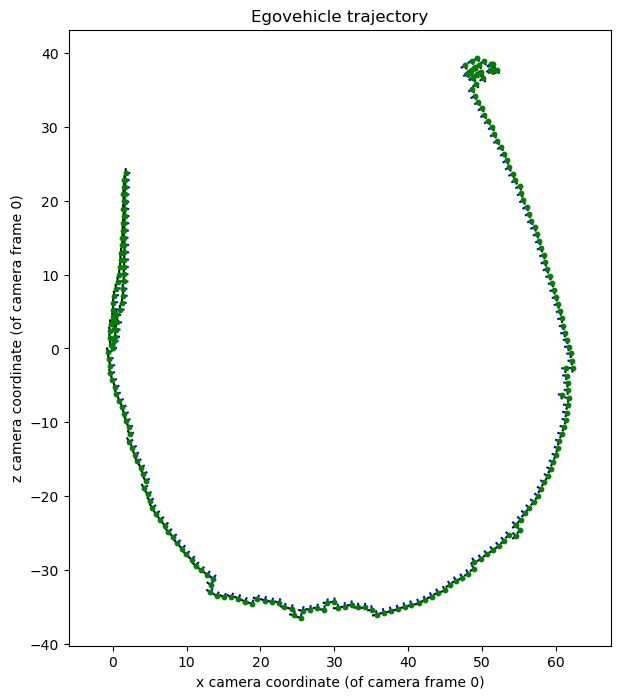

In [99]:
# poses_wTi_gt = np.load('./data/vo_seq_argoverse_273c1883/gt_poses.npy')
plot_poses_no_gt(poses_wTi)
# avg_r_err, avg_t_err = evaluate_poses(poses_wTi, poses_wTi_gt)
# print('Average rotation error (in degree): {}'.format(avg_r_err))
# print('Average angular error of translation (in degree): {}'.format(avg_t_err))